# Image classification using reconstructed output of autoencoder for malaria cell images

## Imports

In [1]:
import os
import glob
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import subtract, Activation, Conv2D, DepthwiseConv2D, MaxPooling2D, Dropout, LeakyReLU

from model_utility import get_image_data

In [2]:
tf.__version__

'2.3.0'

### Set logging to Error only

In [3]:
tf.get_logger().setLevel('ERROR')

### Check for GPU

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Constants

In [5]:
RANDOM_STATE = 7
UNIFECTED_BASE_PATH = r"Malaria Cell Images\Uninfected"
PARASITIZED_BASE_PATH = r"Malaria Cell Images\Parasitized"
IMAGE_SIZE = (128, 128)
VAL_SIZE = 0.05
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
PLOTS_DPI = 200
MODEL_NAME = 'Autoencoder_Classification'
PLOTS_DIR = os.path.join('plots', MODEL_NAME)

## Data Loading

### Label Encoding and Decoding

In [6]:
labelEncoding = {
    'Uninfected' : 0,
    'Parasitized' : 1
}

labelEncoding

{'Uninfected': 0, 'Parasitized': 1}

In [7]:
labelDecoding = {v: k for k, v in labelEncoding.items()}
labelDecoding

{0: 'Uninfected', 1: 'Parasitized'}

### Loading image filenames

In [8]:
uninfectedImageNames = [os.path.basename(file) for file in glob.glob(os.path.join(UNIFECTED_BASE_PATH, '*.png'))]

print(f"\nTotal number of uninfected cell image files: {len(uninfectedImageNames)}")


Total number of uninfected cell image files: 13779


In [9]:
parasitizedImageNames = [os.path.basename(file) for file in glob.glob(os.path.join(PARASITIZED_BASE_PATH, '*.png'))]

print(f"\nTotal number of parasitized cell image files: {len(parasitizedImageNames)}")


Total number of parasitized cell image files: 13779


### Loading image data

In [10]:
%%time

imageData = []
imageLabels = []

for name in tqdm(uninfectedImageNames, desc = 'Loading uninfected image data', unit = ' images'):
    img = get_image_data(os.path.join(UNIFECTED_BASE_PATH, name), IMAGE_SIZE)

    imageData.append(img)
    imageLabels.append(labelEncoding['Uninfected'])

for name in tqdm(parasitizedImageNames, desc = 'Loading parasitized image data', unit = ' images'):
    img = get_image_data(os.path.join(PARASITIZED_BASE_PATH, name), IMAGE_SIZE)

    imageData.append(img)
    imageLabels.append(labelEncoding['Parasitized'])

imageData = np.array(imageData).astype('float32')

imageLabels = np.array(imageLabels)

print(f'\nData type of image data: {imageData.dtype}')
print(f'\nShape of image data: {imageData.shape}')
print(f'\nData type of image labels: {imageLabels.dtype}')
print(f'\nShape of image labels: {imageLabels.shape}')

Loading parasitized image data: 100%|██████████| 13779/13779 [01:41<00:00, 136.04 images/s]

Data type of image data: float32

Shape of image data: (27558, 128, 128, 3)

Data type of image labels: int32

Shape of image labels: (27558,)
Wall time: 3min 35s


### Data splitting

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(
    imageData, 
    imageLabels,
    test_size = VAL_SIZE, 
    random_state = RANDOM_STATE,
    stratify = imageLabels
    )

print(f'Training Images: {X_train.shape}')
print(f'\nTraining Labels: {Y_train.shape}')
print(f'\nValidation Data: {X_val.shape}')
print(f'\nValidation Labels: {Y_val.shape}')

Training Images: (26180, 128, 128, 3)

Training Labels: (26180,)

Validation Data: (1378, 128, 128, 3)

Validation Labels: (1378,)


### Memory usage reduction

In [12]:
del imageData
del imageLabels

## Data Generators

### Training data generator

In [13]:
train_gen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True
    )

train_data = train_gen.flow(x = X_train, y = Y_train, batch_size = BATCH_SIZE, shuffle = True)

len(train_data)

410

### Training data samples

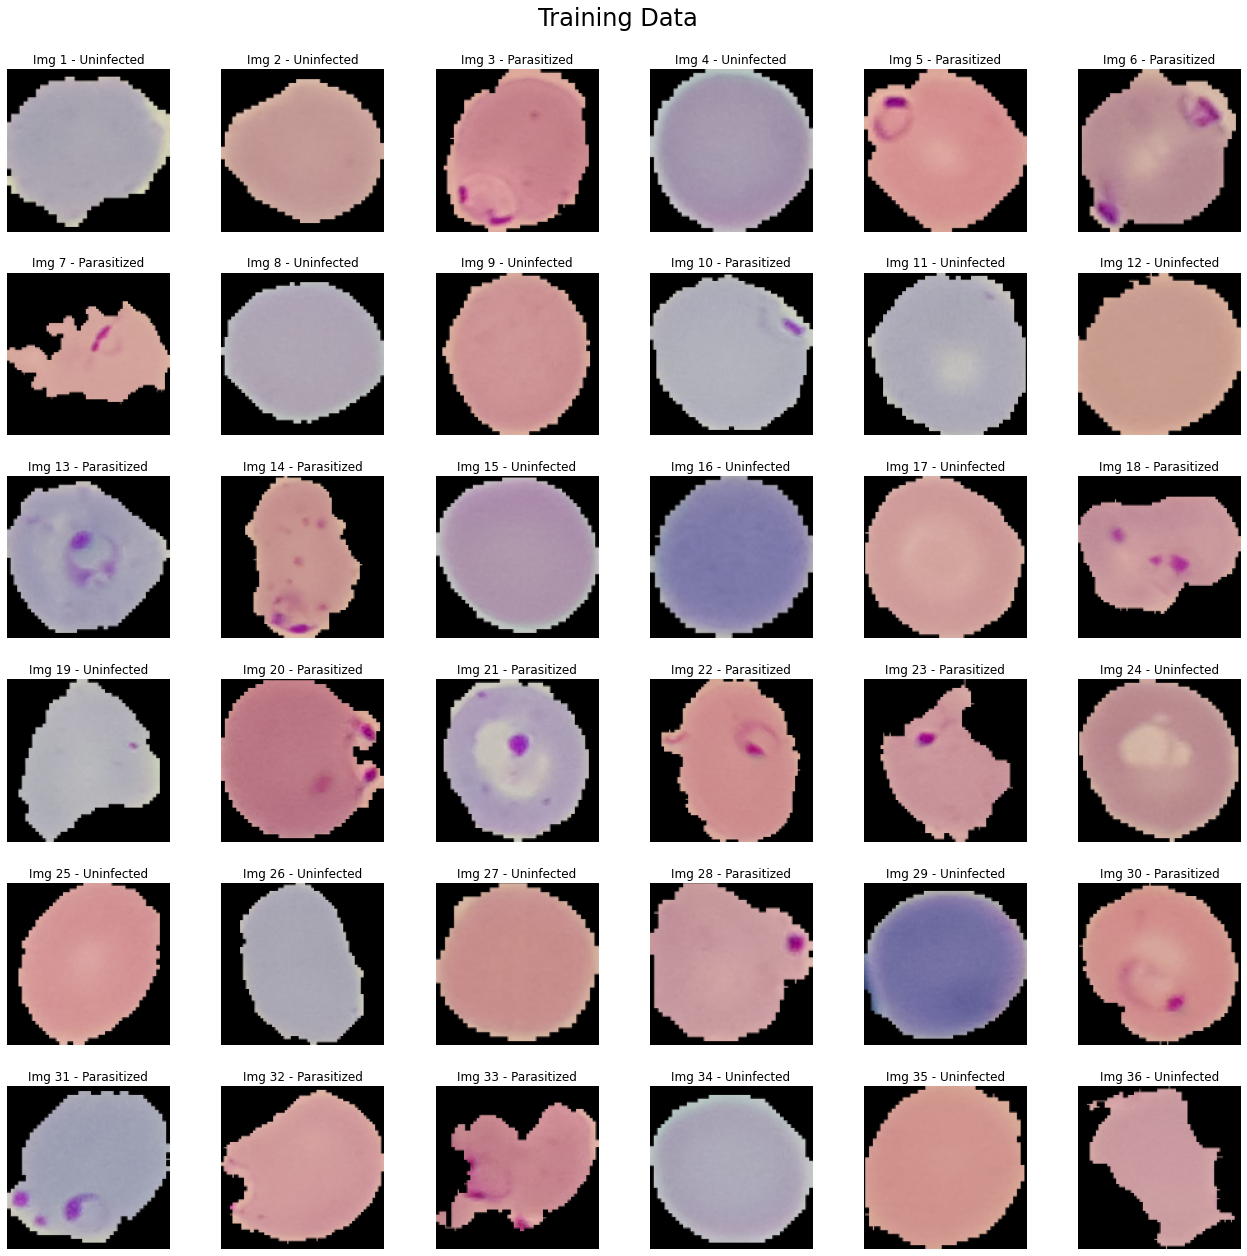

In [14]:
plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))

plt.suptitle('Training Data', fontsize = 24)
plt.tight_layout(rect = [0, 0, 1, 0.97], h_pad = 2)

gen_data = train_data.next()

for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Img {i + 1} - {labelDecoding[gen_data[1][i]]}")
    plt.imshow(gen_data[0][i])

plt.show()

### Validation data generator

In [15]:
val_gen = ImageDataGenerator(rescale = 1./255)

val_data = val_gen.flow(x = X_val, y = Y_val, batch_size = BATCH_SIZE, shuffle = True)

len(val_data)

22

### Validation data samples

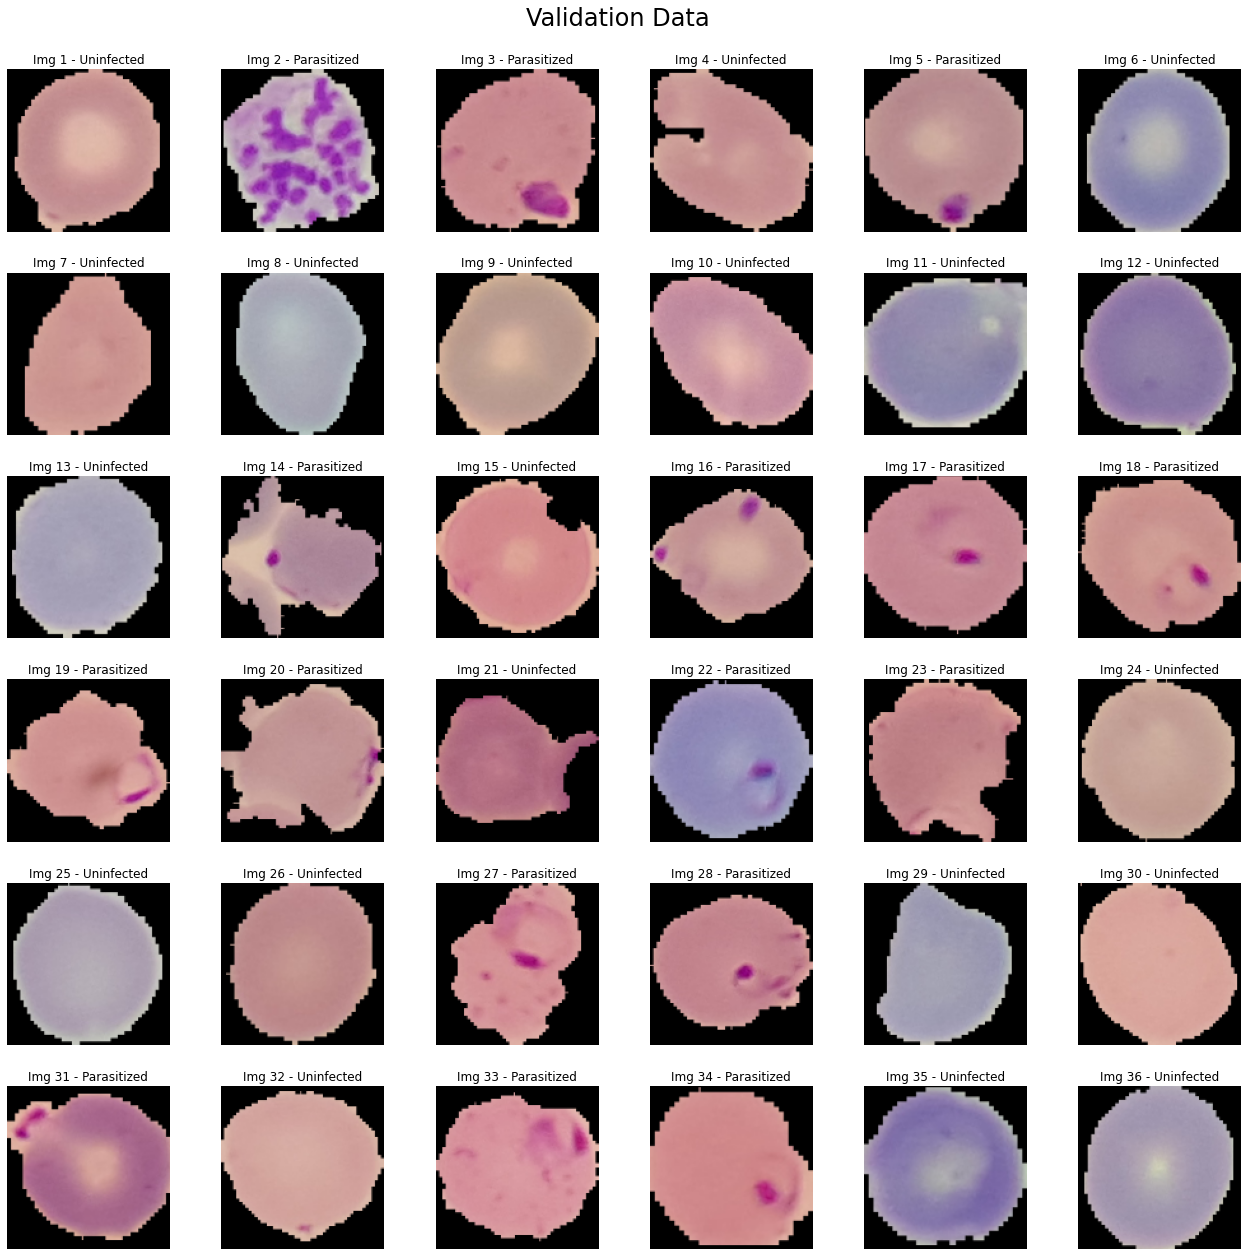

In [16]:
plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))

plt.suptitle('Validation Data', fontsize = 24)
plt.tight_layout(rect = [0, 0, 1, 0.97], h_pad = 2)

gen_data = val_data.next()

for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Img {i + 1} - {labelDecoding[gen_data[1][i]]}")
    plt.imshow(gen_data[0][i])

plt.show()

## Model Creation

### Loading of autoencoder reconstruction model and freezing all existing layers

In [17]:
autoencoder = tf.keras.models.load_model('models/Autoencoder_Reconstruction')

for layer in autoencoder.layers:
    layer.trainable = False

autoencoder.summary()

Model: "Autoencoder_Reconstruction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
Depth_Conv (DepthwiseConv2D) (None, 128, 128, 6)       102       
_________________________________________________________________
Enc_Conv_1 (Conv2D)          (None, 128, 128, 8)       776       
_________________________________________________________________
Enc_MaxPool_1 (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
Enc_Conv_2 (Conv2D)          (None, 32, 32, 16)        2064      
_________________________________________________________________
Enc_MaxPool_2 (MaxPooling2D) (None, 8, 8, 16)          0         
_________________________________________________________________
Enc_Conv_3 (Conv2D)          (None, 8, 8

### Reconstruction Error Layer

In [18]:
reconstructionErrorLayer = subtract([autoencoder.input, autoencoder.output], name = "Reconstruction_Error")
reconstructionErrorLayer.shape

TensorShape([None, 128, 128, 3])

### Error Normalization Layer

In [19]:
errorNormalizationLayer = Activation('sigmoid', name = 'Error_Normalization')(reconstructionErrorLayer)
errorNormalizationLayer.shape

TensorShape([None, 128, 128, 3])

### Model compilation and summary

In [20]:
classifier = Model(inputs = autoencoder.input, outputs = errorNormalizationLayer, name = MODEL_NAME)

classifier.compile(
    optimizer = Adam(LEARNING_RATE), 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['sparse_categorical_accuracy']
    )

classifier.summary()

Model: "Autoencoder_Classification"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Depth_Conv (DepthwiseConv2D)    (None, 128, 128, 6)  102         Input[0][0]                      
__________________________________________________________________________________________________
Enc_Conv_1 (Conv2D)             (None, 128, 128, 8)  776         Depth_Conv[0][0]                 
__________________________________________________________________________________________________
Enc_MaxPool_1 (MaxPooling2D)    (None, 32, 32, 8)    0           Enc_Conv_1[0][0]                 
_________________________________________________________________________

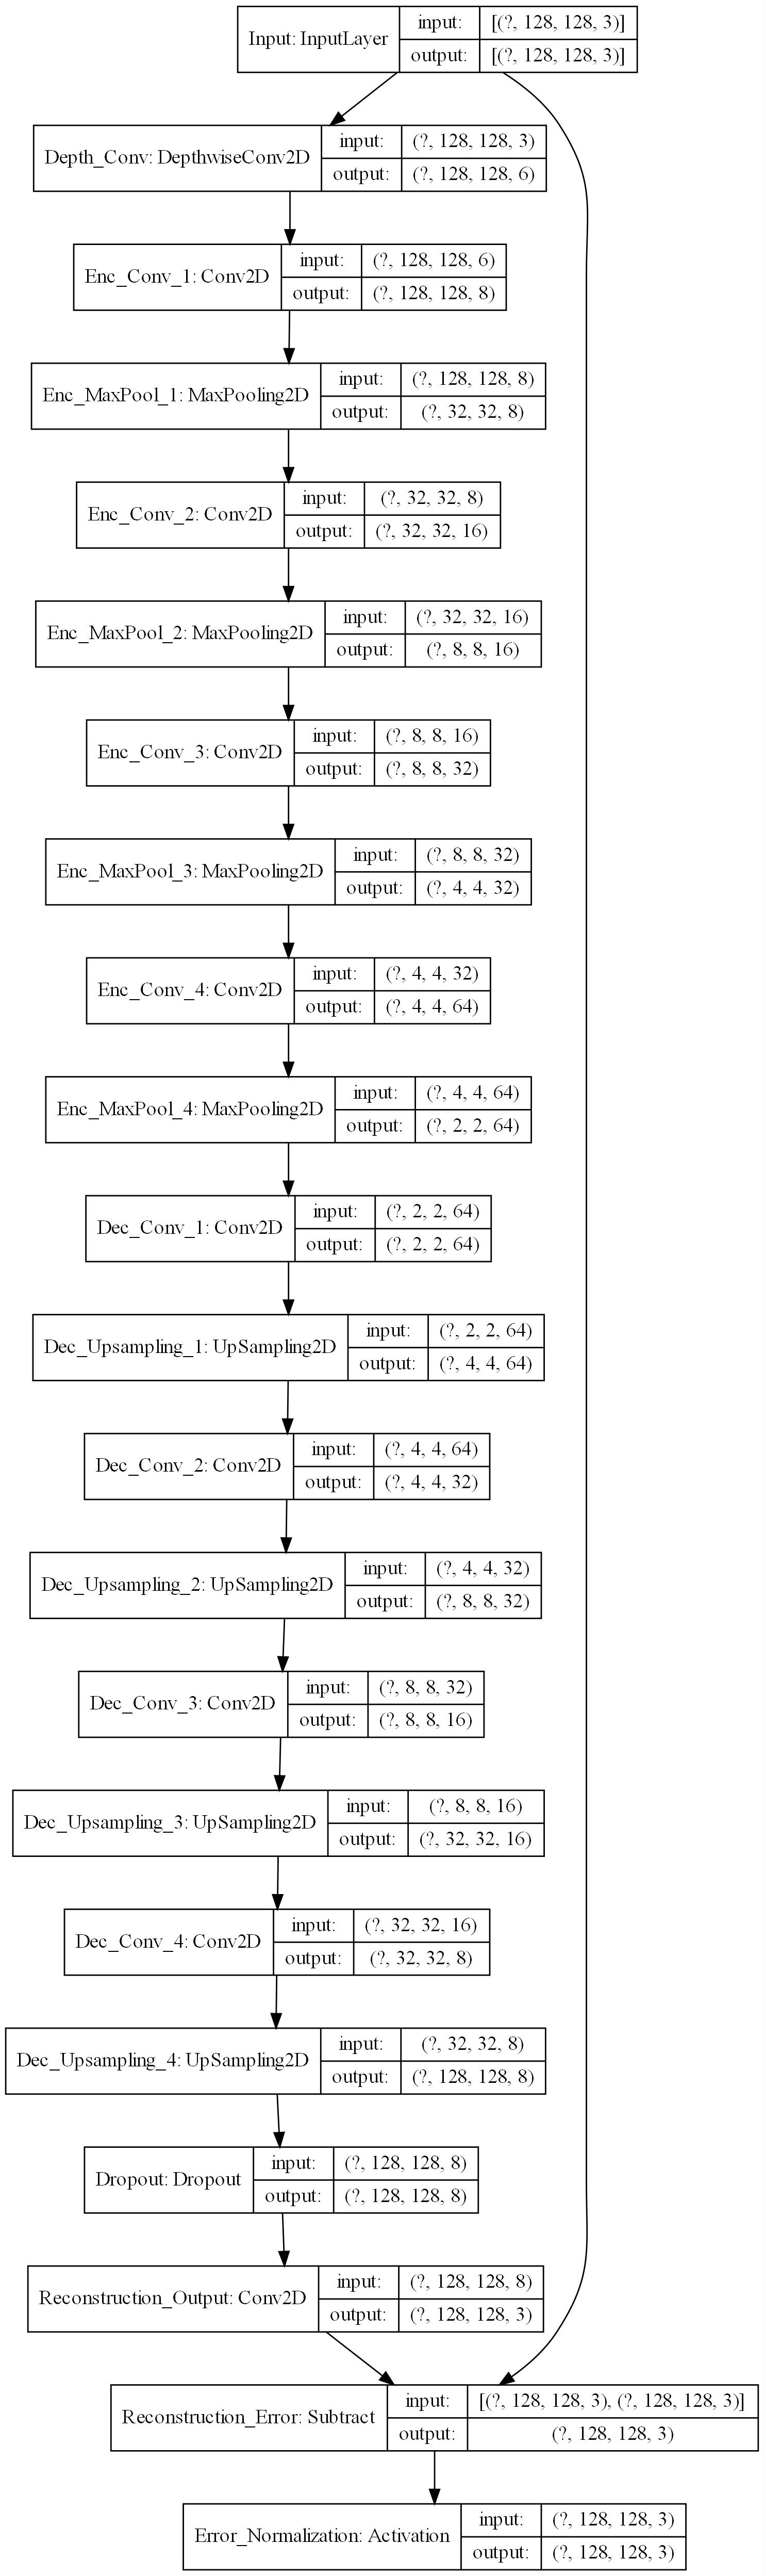

In [21]:
tf.keras.utils.plot_model(classifier, to_file = os.path.join(PLOTS_DIR, 'model.jpg'), show_shapes = True, dpi = PLOTS_DPI)